In [6]:
import pandas as pd
# import pyreadstat as prs #in order to read SPSS files
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_curve, roc_auc_score,r2_score, mean_squared_error  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [32]:
feature = pd.read_csv('classification_feat.csv')
predictor = pd.read_csv('classification_pred.csv', header = 0)
feature['Quarter end'] = pd.to_datetime(feature['Quarter end'])
feature.set_index("Quarter end", inplace=True)
predictor = predictor.drop(columns = 'Unnamed: 0')

In [23]:
features = feature.drop(columns= 'symbol', axis =1)

### Confusion Matrix Function Plot

In [33]:
labels = ['Growth', 'Value']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    
    # Compute confusion matrix
    cmat = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [48]:
def performance_model(model, name, plot=False):
    print(name)
    print('-'*20)
    
    print('** TRAINING PERFORMANCE **')
    print('-> Accuracy Score:', accuracy_score(y_train, model.predict(X_train_scaled)) )
    print('-> Precision Score: {}'.format(precision_score(y_train, model.predict(X_train_scaled))))
    print('-> Recall Score: {}'.format(recall_score(y_train, model.predict(X_train_scaled))))
    print('-> F1 Score: {}'.format(f1_score(y_train, model.predict(X_train_scaled))))
    print('-> AUC:', roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1] ))
    
    print('\n** TESTING PERFORMANCE')
    print('-> Accuracy Score:', accuracy_score(y_test, model.predict(X_test_scaled)) )
    print('-> Precision Score: {}'.format(precision_score(y_test, model.predict(X_test_scaled))))
    print('-> Recall Score: {}'.format(recall_score(y_test, model.predict(X_test_scaled))))
    print('-> F1 Score: {}'.format(f1_score(y_test, model.predict(X_test_scaled))))
    print('-> AUC:', roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1] ))
    print()
    
    if plot:
        fpr, tpr, thres = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1],pos_label=1)
        plt.figure(figsize=(4, 4))
        plt.plot(fpr, tpr, label='Test')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

### PCA - Dimension Reduction

In [34]:
#scale data
sc=StandardScaler()
X_scaled= pd.DataFrame(sc.fit_transform(features),columns=features.columns)

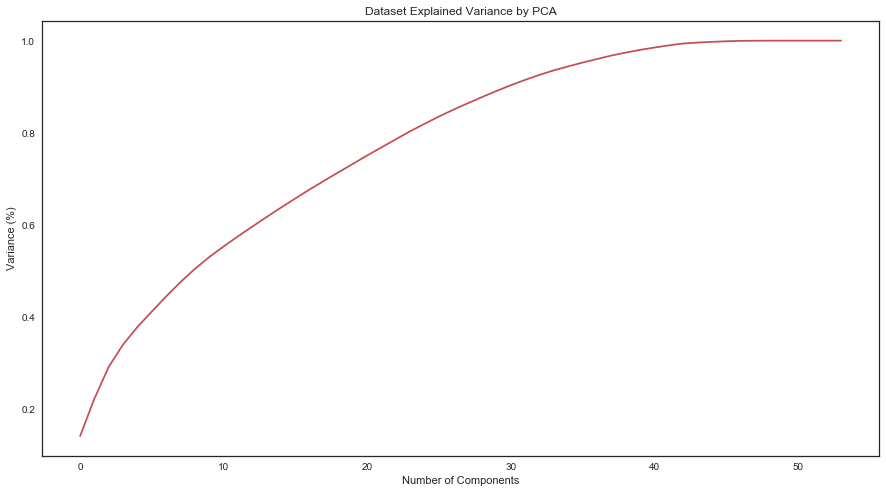

In [35]:
#Fitting the PCA algorithm with the scaled Data
pca = PCA().fit(X_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='r')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance by PCA')
plt.show()

In [36]:
#run PCA for the selected components
pca = PCA(n_components=35)
X_pca = pca.fit_transform(X_scaled)

In [37]:
# Calculate the variance explained by priciple components
print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [0.14104108 0.08154192 0.06922865 0.04826617 0.03815571 0.03336232
 0.03293071 0.03113755 0.02867356 0.02560166 0.02296968 0.02207624
 0.02107166 0.02090692 0.02049033 0.01983183 0.01962027 0.01873016
 0.01846615 0.01823883 0.01822432 0.0176998  0.01758318 0.01751745
 0.01600064 0.01588898 0.01472951 0.01390288 0.01361428 0.01304079
 0.01257132 0.01169136 0.01081679 0.00985031 0.00861813]

 Total Variance Explained: 94.41


In [38]:
#Create the header for the df where I will save the PCA
header = []
for i in range(35):
    header.append("PC"+str(i+1))

In [39]:
# Create a new dataset from principal components only
df_X_pca = pd.DataFrame(data = X_pca
             , columns = header)

print(df_X_pca.shape)
df_X_pca.head(5)

(40566, 35)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,-0.440669,-1.350633,0.485121,0.345464,0.423617,0.088870,0.234014,-1.123574,0.399223,-1.094987,...,1.023427,0.074866,0.090095,-0.616176,-1.081478,0.370358,0.280076,-0.391550,0.008837,-0.054112
1,-0.223331,-1.697407,0.454358,0.547781,-0.101645,0.282980,-0.291215,-0.928791,0.302921,-1.148912,...,1.032025,0.033948,0.011895,-0.627031,-1.090784,0.424182,0.313958,-0.398801,0.040541,-0.020385
2,-0.540656,0.824537,0.772569,-0.889263,-0.641348,0.483775,0.054515,-0.781127,0.512579,-0.870555,...,0.079945,-0.938488,-0.804542,-1.047705,-0.955114,-0.556377,-1.045703,-0.116815,0.661205,0.009193
3,-0.540135,0.793835,0.768972,-0.861197,-0.697229,0.445380,-0.046594,-0.783238,0.513964,-0.900708,...,0.002638,-0.952303,-0.787882,-1.065497,-0.930709,-0.568907,-1.034727,-0.183029,0.661760,0.024011
4,-0.503810,0.865738,0.820356,-0.952181,-0.636348,0.475096,-0.007369,-0.749099,0.473376,-0.871334,...,0.088853,-0.950274,-0.801928,-1.024479,-0.937924,-0.581227,-1.068804,-0.116420,0.615041,0.012177


In [44]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df_X_pca, predictor, test_size=0.2,random_state=45)

In [45]:
#Change the name to run codes for models easier
X_train_scaled= X_train
X_test_scaled = X_test

### Model Testing

In [46]:
svm_SVC = SVC(C=100.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
          probability=True, tol=0.001, cache_size=200, class_weight=None, 
          verbose=0, max_iter=-1, decision_function_shape="ovr", random_state = 0)

In [47]:
svm_SVC.fit(X_train_scaled,y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=0)

In [52]:
print('Accuracy of SVC on training set: {:.2f}'.format(svm_SVC.score(X_train, y_train) * 100))
print('Accuracy of SVC on test set: {:.2f}'.format(svm_SVC.score(X_test, y_test) * 100))

Accuracy of SVC on training set: 94.75
Accuracy of SVC on test set: 90.33


SVM default
--------------------
** TRAINING PERFORMANCE **
-> Accuracy Score: 0.9474916800197214
-> Precision Score: 0.9515280069133475
-> Recall Score: 0.9176452761572846
-> F1 Score: 0.9342795433508176
-> AUC: 0.985155840354649

** TESTING PERFORMANCE
-> Accuracy Score: 0.9032536356913976
-> Precision Score: 0.8989394884591391
-> Recall Score: 0.8620999102602452
-> F1 Score: 0.8801343716597952
-> AUC: 0.9603991434690581



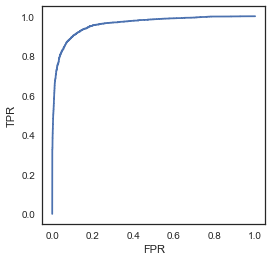

In [49]:
performance_model(svm_SVC,"SVM default",plot=True)

## SVM Grid Search

In [ ]:
svm_param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

svm_grid_search = GridSearchCV(model_pca, svm_param_grid)

%time svm_grid_search.fit(Xtrain, ytrain)
print(svm_grid_search.best_params_)

test_pred_scaled = model_pca.predict(X_test)

In [61]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_pred_scaled)
# print(confusion_matrix(y_test, test_pred_scaled, labels=None, sample_weight=None))
print(f'\n{classification_report(y_test, test_pred_scaled)}')

Precision Score: 0.7372013651877133
Recall Score: 0.6297376093294461
Accuracy Score: 0.7941473259334006
F1 Score: 0.6792452830188679

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       648
           1       0.74      0.63      0.68       343

    accuracy                           0.79       991
   macro avg       0.78      0.76      0.76       991
weighted avg       0.79      0.79      0.79       991



Predicted    0    1  All
True                    
0          549   99  648
1          119  224  343
All        668  323  991


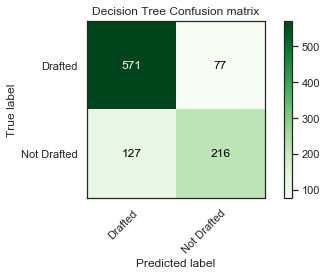

In [70]:
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_pred_scaled, classes=labels,
                      title='SVM Grid Search Confusion matrix')

plt.show()